## 05. Preliminary comparison of the $f_{\rm MM}$ between simulation and data

The notebook is similar to the notebook 02, which builds a major merger catalog. However, here things are done slightly differently: (1) halo pairs are generated, (2) the criteria are applied, rather than the other way around (as shown in notebook 02).

1. Loading data and defining input parameters
2. Finding pairs and creating a major/minor sample
2. Studying merger fraction $f_{MM}$ as a function of redshift

**Script written by**: Soumya Shreeram <br>
**Project supervised by**: Johan Comparat <br>
**Date**: 23rd April 2021

Import required packages

In [1]:
# scipy modules
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d

# astropy modules
import astropy.units as u
import astropy.io.fits as fits

from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM, z_at_value

import numpy as np

# system imports
import os
import sys
import importlib as ib

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Load the imported file(s) that contains all the functions used in this notebooks

In [2]:
%matplotlib inline
font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 20}
matplotlib.rc('font', **font)

In [81]:
sys.path.append('imported_files/')
import Agn_incidence_from_Major_Mergers as aimm
import Comparison_simulation_with_literature_data as cswl
import plotting_cswl05 as pt

### 1. Defining input parameters

In [4]:
# look back into redshifts until...
redshift_limit = 2

# agn parameters
agn_FX_soft = 0

# galaxy parameters
galaxy_SMHMR_mass = 9 # unit: log 10, M_solar

# halo parameters
halo_mass_500c = 10**13.7 # solar masses
central_Mvir = 13.7 # unit: log 10, M_solar
cluster_params = [halo_mass_500c, central_Mvir]

# array deciding the cuts in the merger times and their linestyles
t_merger_cut_arr, l = [1, 2.5, 5], ['-', '--', ':']

# pixel number from the simulation file
pixel_no = '000000'

# number of cluster files for the chosen pixel_no
clu_files_no = 3

# define color palatte
pal = sns.hls_palette(10, h=.5, s=1).as_hex()

Define cosmology used in the notebook

In [5]:
cosmo = FlatLambdaCDM(H0=67.77*u.km/u.s/u.Mpc, Om0=0.307115)
h = 0.6777
L_box = 1000.0 / h

# interpolation function of z -> distance (depends on cosmology)
redshift_step = 0.0001
z_array = np.arange(0,redshift_limit+0.1, step=redshift_step)
f_z_to_comoving_dist = interp1d(z_array, cosmo.comoving_distance(z_array))

Parameters for creating the Major Merger catalogue.

In [21]:
# ratio of masses to call a merger a major merger
mass_ratio_for_MM = 4

# time since merger [Gyr]
time_since_merger = 5

# time since merger array
dt_m_arr = [0.5, 1, 2, 3, 4]

### 2. Open files and get relevant data

In [7]:
hd_agn, hd_halo, _ = edh.getHeaders(pixel_no, np.array(['agn', 'halo']), clu_files_no=clu_files_no)

Extracting positions and redshifts of the AGNs, galaxies, and halos

In [8]:
# agns
pos_z_AGN, _, conditions_agn = edh.getAgnData(hd_agn, agn_FX_soft, redshift_limit)    

# galaxies and halos
pos_z_gal, _, conditions_gal = edh.getGalaxyData(hd_halo, galaxy_SMHMR_mass, redshift_limit)
pos_z_halo, _, conditions_halo = edh.getGalaxyData(hd_halo, '', redshift_limit)

print("AGNs: %d, Galaxies: %d, Halos: %d"%(len(pos_z_AGN[0]), len(pos_z_gal[0]), len(pos_z_halo[0]) ))

AGNs: 1076520, Galaxies: 4503234, Halos: 4506611


### 3.  Finding halo pairs

Get the `hd_file` for all the halo pairs. A quick test to understand how many pairs exists as a function of separation (without any regards to $M^*$, $\Delta t_{\rm MM}$, and $\Delta v$

In [88]:
total_num_pairs = aimm.findPairs(hd_halo)

Note that here the definition of fraction of halo pairs is different to that used later in the notebook.

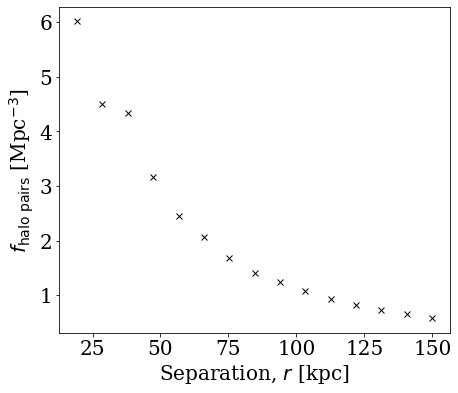

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
r_p, _, shell_volume = aimm.shellVolume()

ax.plot( (1e3*r_p[1:]), total_num_pairs/shell_volume, 'kx')

pt.setLabel(ax, r'Separation, $r$ [kpc]', r'$f_{\rm halo\ pairs}}$ [Mpc$^{-3}$]', '', 'default', 'default', legend=False)
plt.savefig('figures/f_halo_pairs.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')

In [9]:
# get shell volume and projected radius bins
r_p, dr_p, shell_volume = aimm.shellVolume()

mass_max, dv_cut = 3, 500

# if the pairs have already been computed before
run_find_pairs = False

Default values at points:
1. `mass_min = 0.33`, `mass_max = 3`
2. `dv_cut = 500`  

Can change these keywords in functions 1 and 2, respectively.

In [11]:
if run_find_pairs:
    for r in range(len(r_p)):
        print('\n ---- pairs with radius %.2f Mpc ---'%r_p[r])
        pos_spherical = aimm.getSphericalCoord(hd_halo[conditions_halo])

        # create tree
        tree_data = cKDTree(np.transpose(np.abs(pos_spherical)), leafsize=1000.0)

        # list of lists of all pair indicies per DM halo
        pairs_idx = tree_data.query_ball_tree(tree_data, r=r_p[r], p=2) 
        count_pairs, _ = cswl.countPairs(pairs_idx) 

        # (1) choose only major pairs (major mergers)
        all_mm_idx, count_major_pairs = cswl.majorMergerSelection(hd_halo[conditions_halo], pairs_idx)

        # (2) choose only major pairs that satisfy the delta v criteria
        all_dv_idx, count_dv_major_pairs = cswl.deltaVelSelection(hd_halo[conditions_halo], all_mm_idx)
        
        # save file
        np.save('Data/pairs_z%d/pairs_idx_r%d_mm%d_dv%d.npy'%(redshift_limit, r, mass_max, dv_cut), all_dv_idx, allow_pickle=True)

269220 pairs found among 4506611 halos; fraction of pairs: 0.0615
Major merger 3 : 1 cut 137370 selected pairs
Delta v 500 cut: 137370 selected pairs
307575 pairs found among 4506611 halos; fraction of pairs: 0.0706
Major merger 3 : 1 cut 157338 selected pairs
Delta v 500 cut: 157338 selected pairs
347100 pairs found among 4506611 halos; fraction of pairs: 0.0800
Major merger 3 : 1 cut 178012 selected pairs
Delta v 500 cut: 178012 selected pairs
388113 pairs found among 4506611 halos; fraction of pairs: 0.0899
Major merger 3 : 1 cut 199564 selected pairs
Delta v 500 cut: 199564 selected pairs
430101 pairs found among 4506611 halos; fraction of pairs: 0.1001
Major merger 3 : 1 cut 221766 selected pairs
Delta v 500 cut: 221766 selected pairs


The pairs computed in the last step is written to the directory `'Data/pos_z2/'`. Here, the pair indicies generated from the ball tree algorithm are loaded for further analysis.

In [49]:
pairs_all = cswl.openPairsFiles()

Apply the time since major merger criteria. Change keyword `t_since_merger = 1`.

In [42]:
count_t_mm_arr_all_radius = np.zeros( (0, len(r_p) ) )

for dt_m in dt_m_arr:
    count_t_mm_arr = []
    
    for r in range(len(r_p)):    
        _, count_t_mm = cswl.defineTimeSinceMergeCut(hd_halo[conditions_halo], pairs_all[0][r], cosmo, time_since_merger = dt_m)
        count_t_mm_arr.append(count_t_mm)
    
    # save the counts for all radius bins for a given time since merger
    count_t_mm_arr_all_radius = np.append(count_t_mm_arr_all_radius, [count_t_mm_arr], axis=0)
    
np.save('Data/pairs_z%d/all_pairs_t_mm_r.npy'%(redshift_limit), count_t_mm_arr_all_radius, allow_pickle=True)

### 4. Studying the effect of $\Delta t_{\rm merger}$ on MM pairs

Now that all the pairs for the chosen cases of time since major mergers are computed, we can proceed to calculate the fraction of halo pairs for each case.

$$f_{\rm halo\ pairs} = \frac{\rm NP}{\rm N(N-1) \times {\rm Shell\ volume}}$$

where $NP$ is the number of pairs and $N$ is the total number of objects from which pairs are chosen.

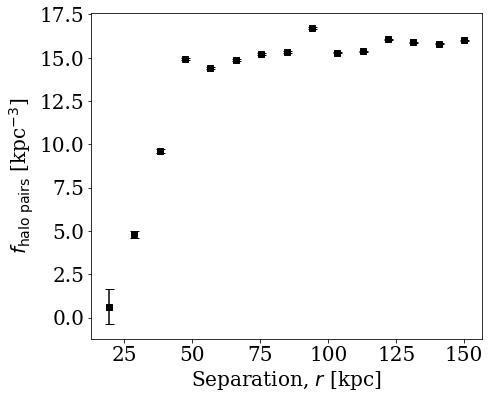

In [80]:
f_pairs, f_pairs_err = cswl.nPairsToFracPairs(hd_halo[conditions_halo], pairs_all[1])

fig, ax = plt.subplots(1,1,figsize=(7,6))

# changing all unit to kpc
r_p_kpc, f_pairs = 1e3*r_p[1:], 1e9*f_pairs

# plotting the results
ax.plot( r_p_kpc , f_pairs, 'ks')
ax.errorbar(r_p_kpc , np.array(f_pairs), yerr=f_pairs_err, ecolor='k', fmt='none', capsize=4.5)

pt.setLabel(ax, r'Separation, $r$ [kpc]', r'$f_{\rm halo\ pairs}}$ [kpc$^{-3}$]', '', 'default', 'default', legend=False)
plt.savefig('figures/f_halo_pairs.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')

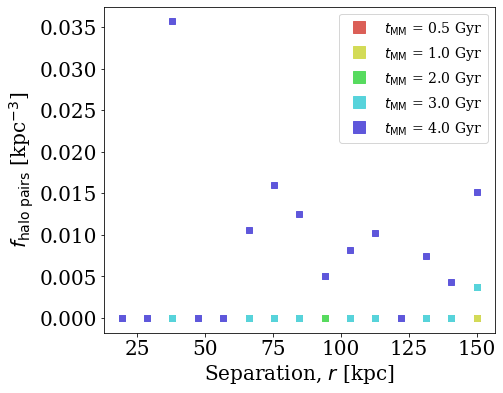

In [117]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
pal = sns.color_palette("hls", len(dt_m_arr)+1).as_hex()
errorbars = [False, False, False, False, False]

for t_idx in range(len(dt_m_arr)):
    n_pairs_dt = count_t_mm_arr_all_radius[t_idx]
    f_p, f_p_err = cswl.nPairsToFracPairs(hd_halo, n_pairs_dt)
    ax = pt.plotFpairs(ax, r_p, np.array(f_p), f_p_err, label = r'$t_{\rm MM}$ = %.1f Gyr'%dt_m_arr[t_idx], color=pal[t_idx], errorbar = errorbars[t_idx])
    
pt.setLabel(ax, r'Separation, $r$ [kpc]', r'$f_{\rm halo\ pairs}}$ [kpc$^{-3}$]', '', 'default', 'default', legend=True)
plt.savefig('figures/f_halo_pairs_dt.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')